# 1. Importação das bibliotecas e tratamento inicial dos dados

In [ ]:
%%capture
!pip install Bayesian-Optimization
!pip install xgboost
!pip install ray

In [ ]:
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import random
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
import requests

import os
import gc
import pdb
import ray
import keras
import tensorflow
from sklearn import metrics
from xgboost import XGBRegressor
from keras.models import load_model
from bayes_opt import BayesianOptimization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cadunico_pca = pd.read_csv("/content/drive/MyDrive/Hunger prediction/data/cadunico_pca.csv")
metrics = pd.read_csv("/content/drive/MyDrive/Hunger prediction/data/hunger_metrics.csv")

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [ ]:
metrics.drop(columns=["Unnamed: 0"], inplace=True)
print(metrics)

                          name  PESO X IDADE / Peso Muito Baixo para a Idade  \
0                      abaiara                                          0.69   
1                      acarape                                          0.54   
2                       acarau                                          0.44   
3                     acopiara                                          0.87   
4                       aiuaba                                          0.47   
5                   alcantaras                                          0.32   
6                    altaneira                                          0.92   
7                   alto santo                                          0.71   
8                     amontada                                          0.33   
9            antonina do norte                                          0.00   
10                    apuiares                                          0.63   
11                     aquiraz          

In [ ]:
#ìndices das linhas do df em que 'CMI' tem NaN
indices_nulos = metrics[metrics['CMI'].isna()].index

# Novo DataFrame sem as linhas com valores NaN em 'CMI'
metrics = metrics.drop(indices_nulos)

print(metrics)

                          name  PESO X IDADE / Peso Muito Baixo para a Idade  \
0                      abaiara                                          0.69   
1                      acarape                                          0.54   
2                       acarau                                          0.44   
3                     acopiara                                          0.87   
4                       aiuaba                                          0.47   
5                   alcantaras                                          0.32   
7                   alto santo                                          0.71   
8                     amontada                                          0.33   
9            antonina do norte                                          0.00   
10                    apuiares                                          0.63   
11                     aquiraz                                          1.97   
12                     aracati          

In [ ]:
# Novo DataFrame sem as linhas com valores NaN em 'CMI'
cadunico_pca = cadunico_pca.drop(indices_nulos)

cadunico_pca

,Município,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,pc_7,pc_8,pc_9,pc_10,pc_11,pc_12,pc_13,pc_14,pc_15,pc_16,pc_17,pc_18,pc_19,pc_20,pc_21,pc_22,pc_23,pc_24,pc_25,pc_26,pc_27,pc_28,pc_29,pc_30,pc_31,pc_32,pc_33,pc_34,pc_35,pc_36,pc_37,pc_38,pc_39,pc_40,pc_41,pc_42,pc_43,pc_44,pc_45,pc_46,pc_47,pc_48,pc_49,pc_50,pc_51,pc_52,pc_53,pc_54,pc_55,pc_56,pc_57,pc_58,pc_59,pc_60,pc_61,pc_62,pc_63,pc_64,pc_65,pc_66,pc_67,pc_68,pc_69,pc_70,pc_71,pc_72,pc_73,pc_74,pc_75,pc_76,pc_77,pc_78,pc_79,pc_80,pc_81,pc_82,pc_83,pc_84,pc_85,pc_86,pc_87,pc_88,pc_89,pc_90,pc_91,pc_92,pc_93,pc_94,pc_95,pc_96,pc_97,pc_98,pc_99,pc_100,pc_101,pc_102,pc_103,pc_104,pc_105,pc_106,pc_107,pc_108,pc_109,pc_110,pc_111,pc_112,pc_113,pc_114,pc_115,pc_116,pc_117
0,abaiara,0.909037,1.411531,-2.009080,1.273723,-4.484937,0.928649,2.576158,-0.231018,-0.637624,-2.344075,1.828871,2.524196,-0.455517,-0.179312,-0.563414,2.679475,0.417502,-0.294738,-0.933825,0.305719,-0.684745,0.864986,-1.443222,-0.188149,-1.024488,-1.527550,-1.217833,-0.716385,-0.763641,0.155937,-0.186825,-1.305830,1.615400,-0.219660,0.499044,-1.764376,-0.413343,-0.945728,-0.311493,-0.158862,1.696927,0.417107,0.390798,0.275250,-0.216778,-0.651223,-0.194677,1.123314,1.416144,-1.291248,0.438839,-0.534997,-0.050953,1.834906,-0.609948,-0.027921,-0.180196,0.420107,-0.146671,0.478700,-0.303394,0.005258,-0.113624,0.079117,-0.041201,0.229572,0.300062,0.031663,-0.438545,-0.265928,0.208702,-0.148927,0.314288,-0.112894,-0.367687,0.275302,-0.661852,-0.299656,0.013105,0.491303,0.089097,0.157765,0.034975,-0.065527,-0.575389,-0.103143,0.021064,-0.003109,-0.004513,-0.061911,0.100914,0.017509,-0.014824,-0.028519,0.021739,0.001316,0.000682,-0.000333,-0.000664,-0.000400,-0.000509,0.000345,0.000127,1.448631e-05,-0.000138,3.081238e-04,-0.000247,-0.000151,-6.036117e-06,-0.000025,0.000136,2.648380e-13,-4.099649e-14,4.678895e-16,-1.651873e-16,-2.123939e-16,-3.785838e-16
1,acarape,-0.199619,-3.821894,4.499563,-0.162677,0.529191,0.706435,-0.765329,-3.102003,1.522149,2.087833,-3.617069,1.292302,2.601272,-2.131336,-0.161877,0.517940,3.820060,2.170087,1.206195,-1.560534,0.751207,-0.017205,-0.032034,-0.353542,1.121924,0.578828,-1.553725,-0.049419,-1.112927,2.821912,0.766232,0.656711,-0.542350,0.225125,0.439106,-1.100519,-2.013145,0.391836,0.325904,0.302403,-0.788717,-1.071058,-0.739985,2.275477,-0.145049,-0.240876,-1.550864,0.396717,0.300441,0.761697,0.479144,-1.010247,-0.397769,0.578299,-0.844085,-0.098276,-0.217387,-0.896503,-0.376577,0.580311,-0.930283,-0.046268,0.051611,-0.397456,-0.092882,-0.183327,0.849214,0.373739,0.525688,0.448857,0.883268,-0.390974,-0.169754,0.014421,-0.149940,-0.099265,0.043338,-0.546803,-0.179020,-0.242604,-0.336244,-0.123581,-0.075698,-0.473959,-0.044005,-0.202235,0.127592,-0.136044,0.088384,0.146643,-0.009607,0.070559,-0.054995,-0.011812,0.016872,-0.000863,-0.000215,0.000369,-0.000007,0.000277,-0.000425,0.000013,-0.000336,-4.101556e-04,-0.000202,-1.087290e-04,-0.000058,0.000135,5.753147e-05,-0.000055,0.000121,-2.312815e-13,7.337910e-15,2.682893e-16,1.160496e-17,3.006351e-16,-3.395572e-16
2,acarau,-5.889520,-3.462552,-0.796370,0.579979,2.197895,-1.147328,2.309388,2.006473,-0.501712,0.325099,-0.615748,0.104987,-0.812516,2.556157,1.699051,0.539604,1.061833,0.581043,-0.810778,0.716949,-0.967842,-0.416273,-0.316289,-1.320935,-0.118191,0.401969,-1.131552,-0.236336,-0.011506,-0.569544,0.964772,0.683596,0.259770,0.168286,0.958485,-0.723991,-0.879174,1.644171,0.511262,-0.652095,-0.614723,-1.299357,0.002977,-0.382724,-0.579747,-1.285552,0.385443,-0.424022,0.208459,0.687161,0.136973,0.580427,-0.050148,-0.483109,-0.465412,-0.146955,-0.478983,-0.820840,0.739533,0.724582,0.068230,-0.105278,0.097833,0.579700,-0.830815,-0.338152,-0.021876,0.380102,-0.168917,0.435595,-0.202996,-0.151245,-0.579793,0.286272,-0.322500,-0.189177,0.075943,0.174631,0.181630,-0.219291,-0.252763,0.388024,0.005805,0.205751,0.153734,-0.331493,0.150896,-0.082271,-0.007261,0.193542,-0.074106,-0.124129,0.004991,-0.004787,-0.016041,0.002144,-0.000151,0.001041,0.000

# 2. Modelos de regressão

In [ ]:
def plot_results(y_pred, y_tes):
  plt.rcParams["figure.figsize"] = (20,6)

  plt.scatter(range(len(y_pred)), y_pred, c='r')
  plt.plot(range(len(y_tes)), y_tes, linestyle="-", marker="o", label="Expenses")
  plt.title('Model performance - test set')
  plt.xlabel('Sample')
  plt.legend(['predicted', 'real'], loc='upper left')
  plt.show()

In [ ]:
column = 3

In [ ]:
x_tr, x_te, y_tr, y_te = train_test_split(cadunico_pca[cadunico_pca.columns[1:73]], metrics[metrics.columns[column]], test_size=0.15, random_state=3)

## 2.1. Modelos Lineares

In [ ]:
import sklearn.model_selection as skms
import sklearn.linear_model as sklm
import sklearn as sk
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score, mean_absolute_percentage_error

In [ ]:
def train_test_model(model, x_tr, y_tr, x_te, y_te, folds=5):
  kf = KFold(n_splits = folds, random_state = 1, shuffle=True)
  scores = cross_validate(model, x_tr, y_tr, cv=kf,
                        scoring = ('neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'r2'))

  mae = np.mean(scores['test_neg_mean_absolute_error']*(-1))
  std_mae = np.std(scores['test_neg_mean_absolute_error']*(-1))

  mape = np.mean(scores['test_neg_mean_absolute_percentage_error']*(-1))
  std_mpae = np.std(scores['test_neg_mean_absolute_percentage_error']*(-1))

  r2 = np.mean(scores['test_r2'])
  std_r2 = np.std(scores['test_r2'])

  print('--------------------Validação Cruazada-----------------------')
  print("Média dos valores de MAE: " + str(mae))
  print("Desvio padrão dos valores de MAE: " + str(std_mae) + "\n")

  print("Média dos valores de MAPE: " + str(mape))
  print("Desvio padrão dos valores de MAPE: " + str(std_mpae) + "\n")

  print("Média dos valores de R2: " + str(r2))
  print("Desvio padrão dos valores de R2: " + str(std_r2) + "\n")

  print('--------------------Teste-----------------------')
  y_pred = model.predict(x_te)
  print("MAE: " + str(mean_absolute_error(y_te, y_pred)))
  print("MAPE: " + str(mean_absolute_percentage_error(y_te, y_pred)))
  print("R2: " + str(r2_score(y_te, y_pred)))

  plot_results(model.predict(x_te), y_te)

### 2.1.1. Regressão Linear

In [ ]:
mask_nan = y_tr.isna()  # Ou data.isnull()
num_nan = mask_nan.sum()
print("Número de valores NaN na série:", num_nan)
quantidade_relativa_nan = num_nan / len(y_tr)
print("Quantidade relativa de NaN na série:", quantidade_relativa_nan)

Número de valores NaN na série: 0
Quantidade relativa de NaN na série: 0.0


In [ ]:
linear_regressor = sklm.LinearRegression()
linear_regressor.fit(x_tr, y_tr)

LinearRegression()

**Teste com 5-Folds**

--------------------Validação Cruazada-----------------------
Média dos valores de MAE: 171.1594219660836
Desvio padrão dos valores de MAE: 37.4394076730389

Média dos valores de MAPE: 5.1057405672558195e+17
Desvio padrão dos valores de MAPE: 1.8085385442211472e+17

Média dos valores de R2: -49.99912213844902
Desvio padrão dos valores de R2: 40.83849339071537

--------------------Teste-----------------------
MAE: 148.64557087270944
MAPE: 3.14789359315386e+17
R2: -0.41607399468617756


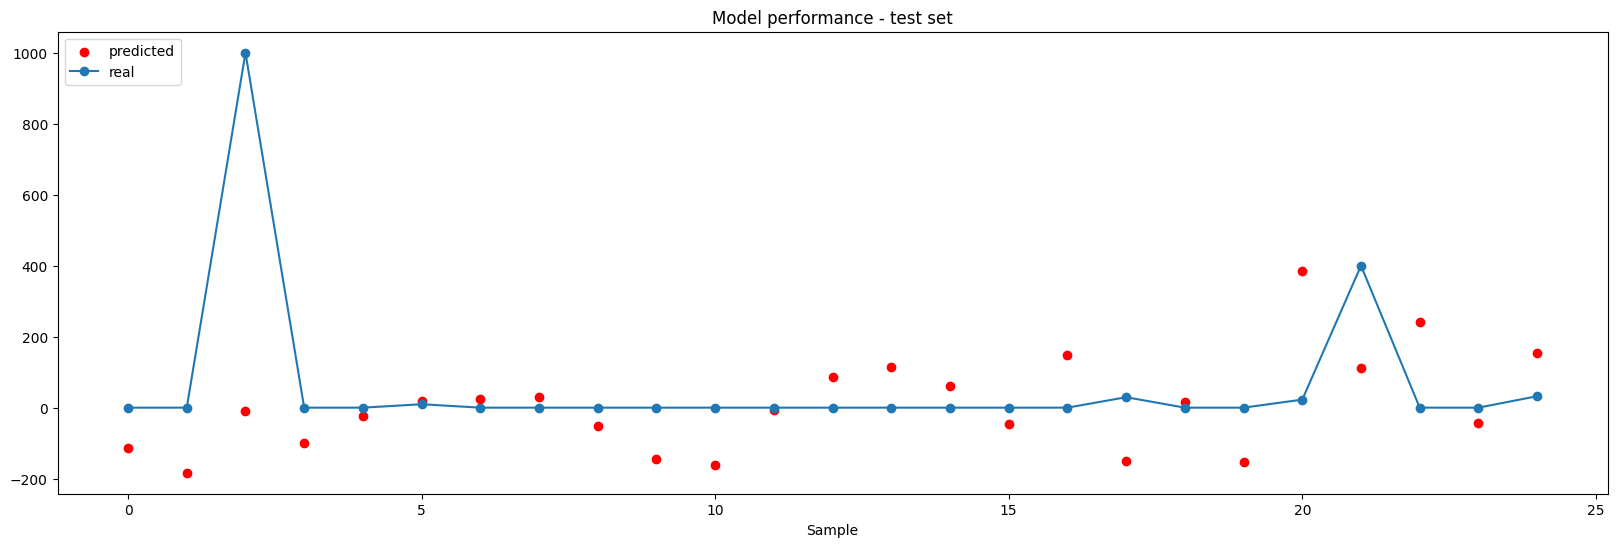

In [ ]:
train_test_model(linear_regressor, x_tr, y_tr, x_te, y_te, folds=5)

**Teste com 10-Folds**

--------------------Validação Cruazada-----------------------
Média dos valores de MAE: 129.97755653243468
Desvio padrão dos valores de MAE: 27.35171012466053

Média dos valores de MAPE: 3.742607241274853e+17
Desvio padrão dos valores de MAPE: 1.474950958641494e+17

Média dos valores de R2: -1255.4785758425971
Desvio padrão dos valores de R2: 2087.3955522242077

--------------------Teste-----------------------
MAE: 148.64557087270944
MAPE: 3.14789359315386e+17
R2: -0.41607399468617756


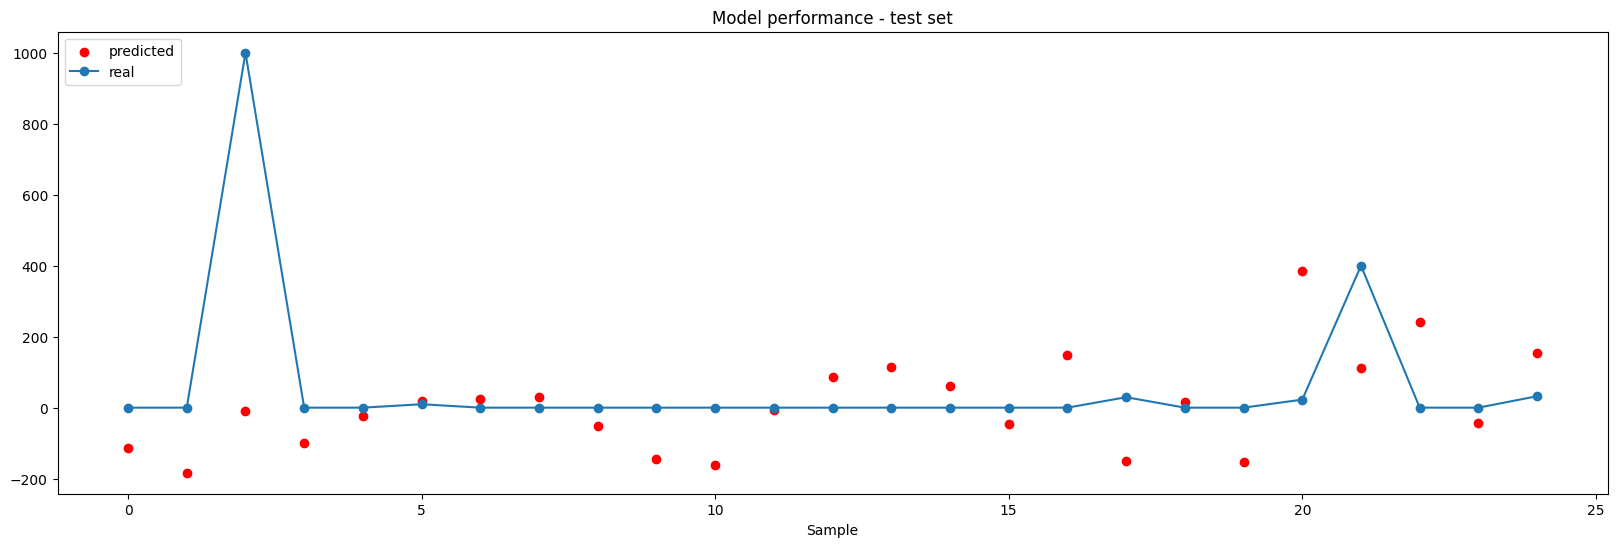

In [ ]:
train_test_model(linear_regressor, x_tr, y_tr, x_te, y_te, folds=10)

### 2.1.2. Rgressão Ridge

In [ ]:
ray.init()

2023-11-09 19:44:27,361	INFO worker.py:1673 -- Started a local Ray instance.


Python version:,3.10.12
Ray version:,2.8.0


In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [ ]:
# definindo espaço de busca para os lambdas
lambdas = np.linspace(0, 10000, 1000)

In [ ]:
fld = 5

In [ ]:
@ray.remote

def test_lambda(lamb):
  # aplicando a regressão
  global fld

  ridge = sklm.Ridge(alpha = lamb)
  ridge.fit(x_tr, y_tr)             # Fit a ridge regression on the training data

  scores = skms.cross_validate(ridge, x_tr, y_tr, cv=fld,
                               scoring=('r2', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error'))

  mae = np.mean(scores['test_neg_mean_absolute_error']*(-1))
  mape = np.mean(scores['test_neg_mean_absolute_percentage_error']*(-1))
  r2 = np.mean(scores['test_r2'])

  return [mae, mape, r2]

In [ ]:
def show_ridge_results():
  result_values = ray.get([test_lambda.remote(i) for i in lambdas])
  scores_MAE = [result[0] for result in result_values]
  scores_MAPE = [result[1] for result in result_values]
  scores_R2 = [result[2] for result in result_values]

  best_index = scores_MAE.index(min(scores_MAE))

  print("Lambda:" + str(lambdas[best_index]))
  print("Best MAE: " + str(scores_MAE[best_index]))
  print("Best MAPE: " + str(scores_MAPE[best_index]))
  print("R2: " + str(scores_R2[best_index]))

  ridge = sklm.Ridge(alpha = lambdas[best_index])
  ridge.fit(x_tr, y_tr)
  plot_results(ridge.predict(x_te), y_te)

**Teste com 5-Folds**

Lambda:10000.0
Best MAE: 36.297889709153836
Best MAPE: 6.828239104155674e+16
R2: -5.3117307809801835


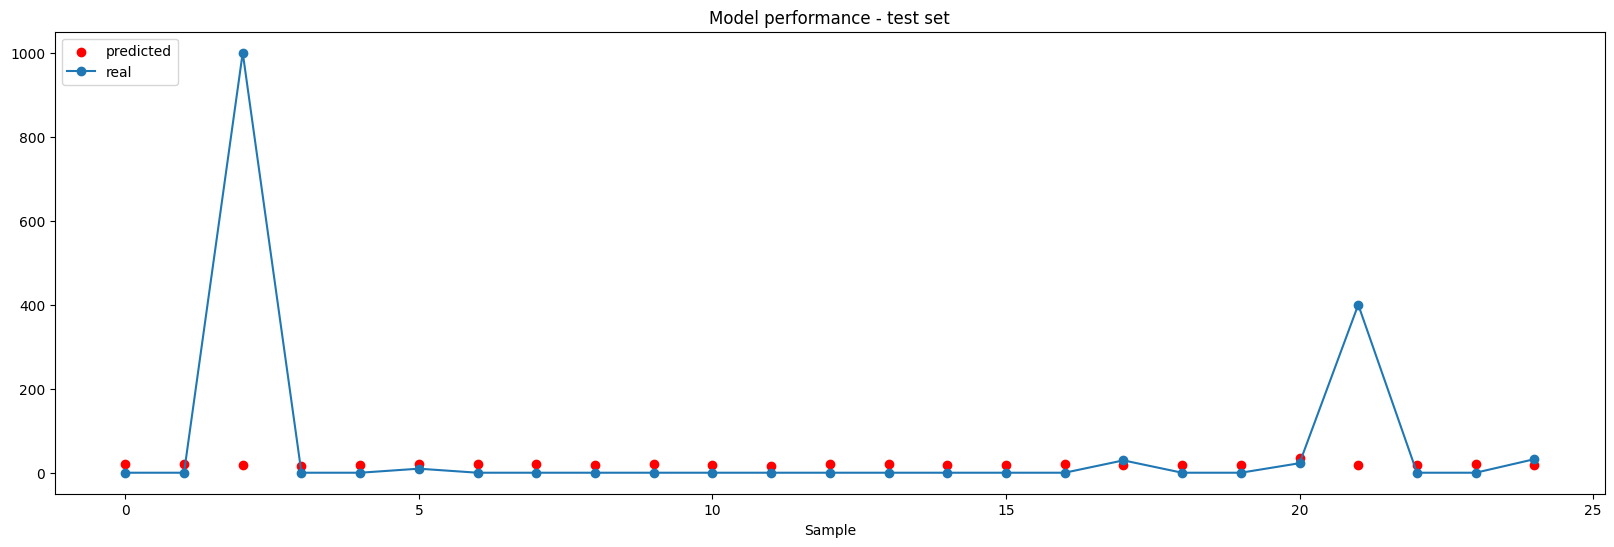

In [ ]:
show_ridge_results()

**Teste com 10-Folds**

Lambda:10000.0
Best MAE: 36.297889709153836
Best MAPE: 6.828239104155674e+16
R2: -5.3117307809801835


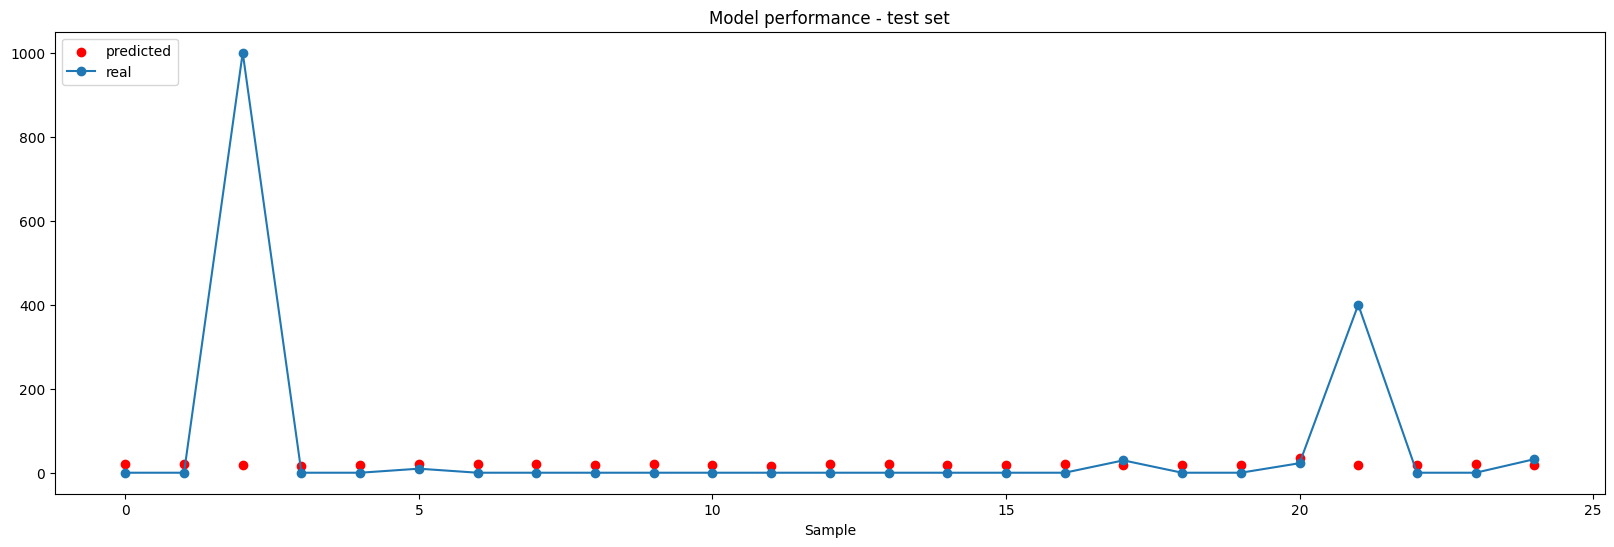

In [ ]:
fld = 10
show_ridge_results()

**Teste com 20-Folds**

Lambda:10000.0
Best MAE: 36.297889709153836
Best MAPE: 6.828239104155674e+16
R2: -5.3117307809801835


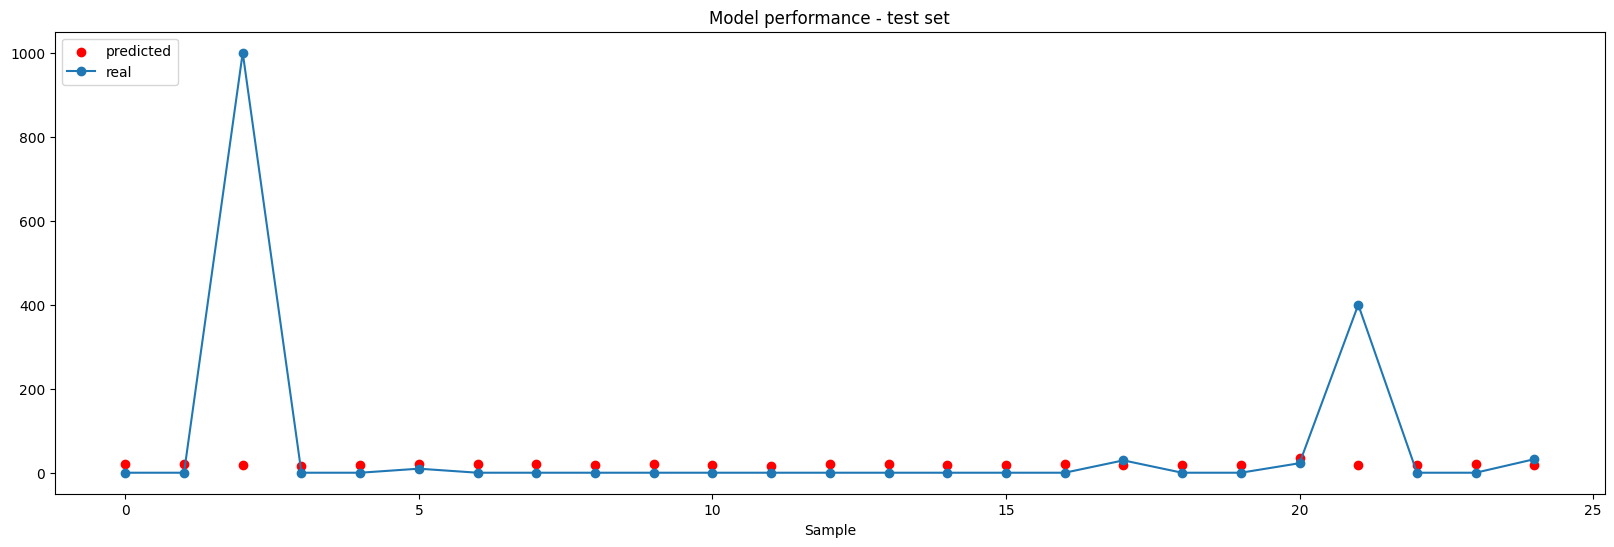

In [ ]:
fld = 20
show_ridge_results()

## 2.2 Modelos não lineares

### 2.2.1. SVM

In [ ]:
from sklearn import svm

In [ ]:
svm_regressor = svm.SVR()
svm_regressor.fit(x_tr, y_tr)

SVR()

**Teste com 5-Folds**

--------------------Validação Cruazada-----------------------
Média dos valores de MAE: 21.17601969369365
Desvio padrão dos valores de MAE: 21.54787139744853

Média dos valores de MAPE: 1304796444388784.8
Desvio padrão dos valores de MAPE: 455113667000961.1

Média dos valores de R2: -0.07343100803506272
Desvio padrão dos valores de R2: 0.013271648043720467

--------------------Teste-----------------------
MAE: 59.87957793874793
MAPE: 751731856812772.6
R2: -0.08347144695752173


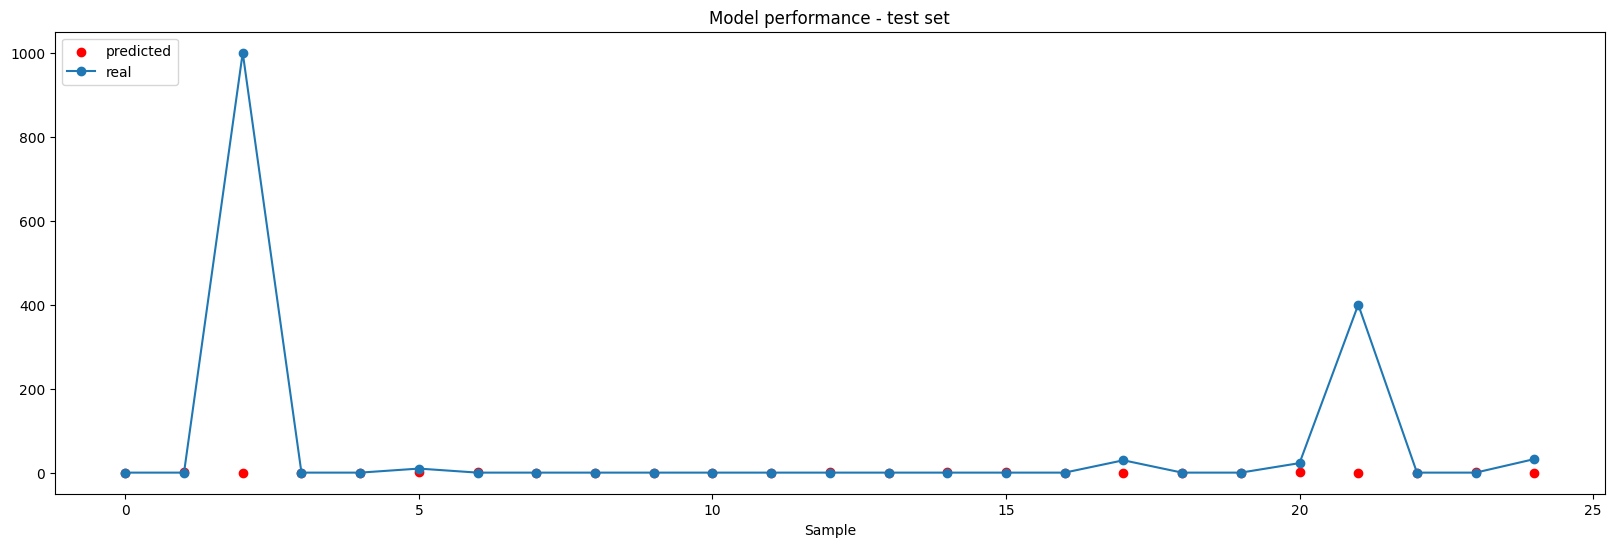

In [ ]:
train_test_model(svm_regressor, x_tr, y_tr, x_te, y_te, folds=5)

**Teste com 10-Folds**

--------------------Validação Cruazada-----------------------
Média dos valores de MAE: 21.27144675512021
Desvio padrão dos valores de MAE: 28.889237569521327

Média dos valores de MAPE: 1203959270052491.0
Desvio padrão dos valores de MAPE: 493146984700037.8

Média dos valores de R2: -0.11978346039834183
Desvio padrão dos valores de R2: 0.0458607537544208

--------------------Teste-----------------------
MAE: 59.87957793874793
MAPE: 751731856812772.6
R2: -0.08347144695752173


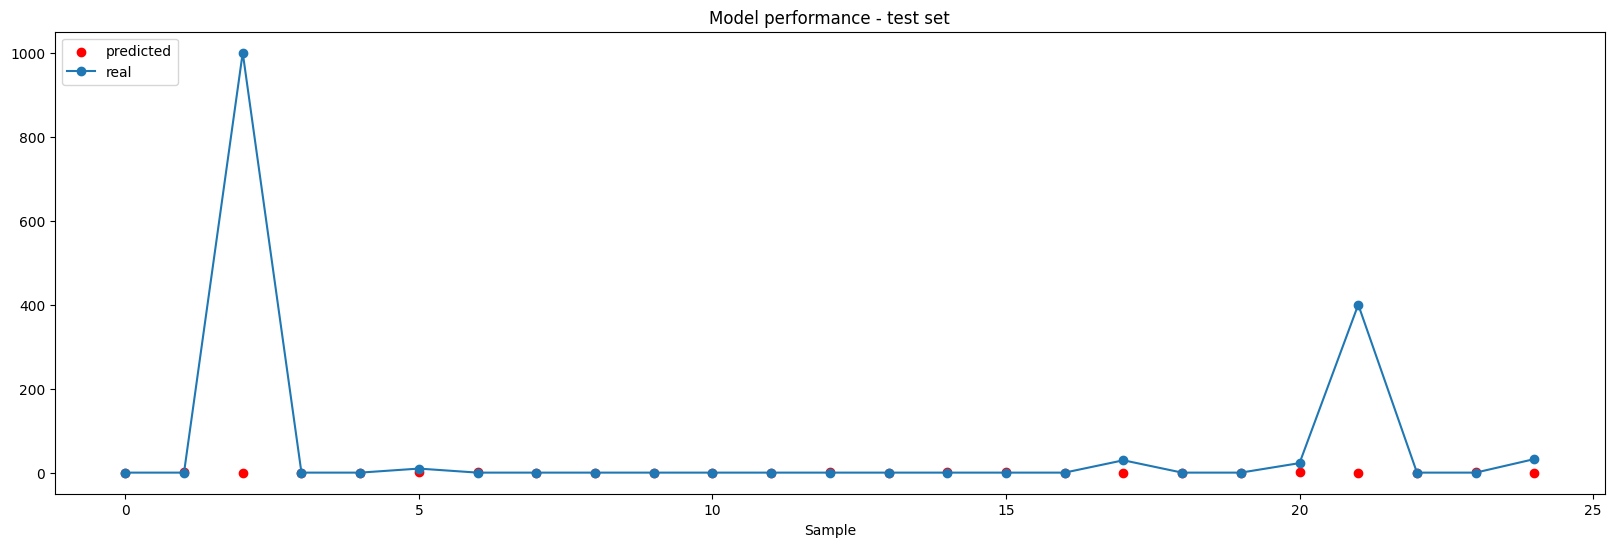

In [ ]:
train_test_model(svm_regressor, x_tr, y_tr, x_te, y_te, folds=10)

### 2.2.2. Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor as rf

In [ ]:
rf_regressor = rf(n_estimators=1000, random_state=1)
rf_regressor.fit(x_tr, y_tr)

RandomForestRegressor(n_estimators=1000, random_state=1)

**Teste com 5-Folds**

--------------------Validação Cruazada-----------------------
Média dos valores de MAE: 53.93450782613136
Desvio padrão dos valores de MAE: 14.586999025996144

Média dos valores de MAPE: 1.1900748285799056e+17
Desvio padrão dos valores de MAPE: 5.335120636803178e+16

Média dos valores de R2: -8.690907794488044
Desvio padrão dos valores de R2: 7.747594263498996

--------------------Teste-----------------------
MAE: 94.40559122124107
MAPE: 1.199176156079881e+17
R2: -0.19814552005315988


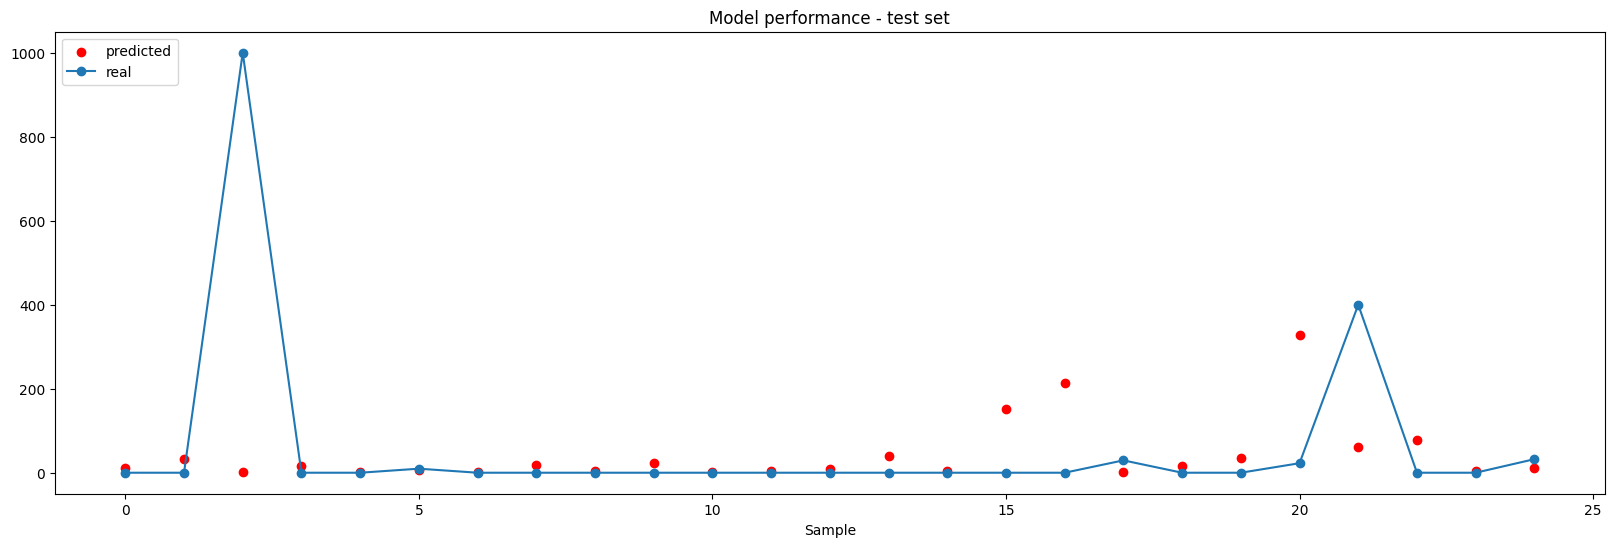

In [ ]:
train_test_model(rf_regressor, x_tr, y_tr, x_te, y_te, folds=5)

**Teste com 10-Folds**

--------------------Validação Cruazada-----------------------
Média dos valores de MAE: 51.07343127541988
Desvio padrão dos valores de MAE: 29.820721367162395

Média dos valores de MAPE: 1.0807572151687104e+17
Desvio padrão dos valores de MAPE: 6.362931975005749e+16

Média dos valores de R2: -259.5987820671828
Desvio padrão dos valores de R2: 598.7654128530268

--------------------Teste-----------------------
MAE: 94.40559122124107
MAPE: 1.199176156079881e+17
R2: -0.19814552005315988


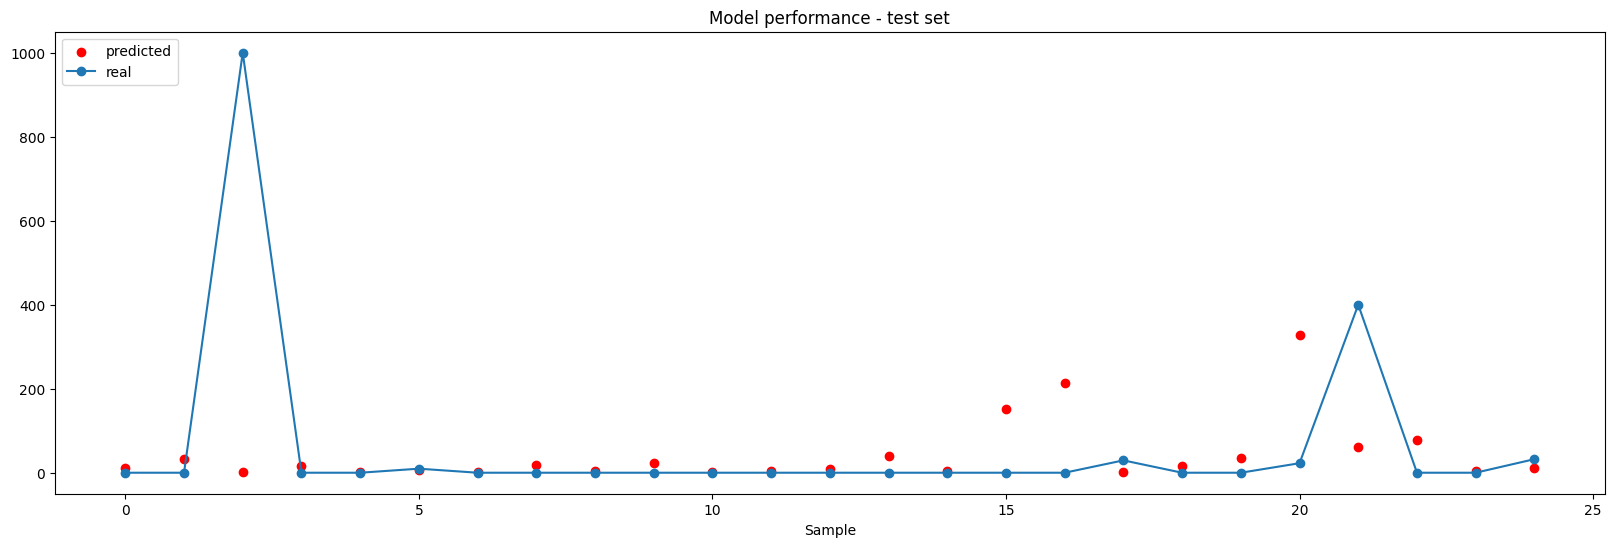

In [ ]:
train_test_model(rf_regressor, x_tr, y_tr, x_te, y_te, folds=10)

### 2.2.3 XGBoost

In [ ]:
x_rem, x_te, y_rem, y_te = train_test_split(cadunico_pca[cadunico_pca.columns[1:73]], metrics[metrics.columns[column]], test_size=0.1, random_state=3)
x_tr, x_va, y_tr, y_va = train_test_split(x_rem, y_rem, test_size=0.1, random_state=3)

###3.3.3. XGBoost

**Uma brever explicação de como treinaremos este modelo (o mesmo vale para o *multilayer perceptron* - MLP):**



*   Utilizaremos um algoritmo de otimização (otimização Bayesiana) para otimizar os hiperparâmetros dos modelos. Basicamente, hiperparâmetros são valores configuráveis que podem alterar a forma como o modelo aprende, por exemplo, em uma rede neural multicamadas (MLP) os hiperparâmetros podem ser o número de camadas, o número de nurônios em cada camada, o número de amostras passadas por vez para o modelo durante o treinamento, etc

*   Salvaremos os melhores hiperparâmetros obtidos e o melhor modelo obtido na etapa de cross validation.



In [ ]:
best = np.inf

In [ ]:
def cross_validation_xgb(x_train, y_train, params, folds=5):

  global best

  kf = KFold(n_splits=folds, random_state=1, shuffle=True)
  x_tr = np.array(x_train)
  y_tr = np.array(y_train)
  histories = []
  models = []
  results = []

  for train_index, test_index in kf.split(x_tr):
    xtr, xva = x_tr[train_index], x_tr[test_index]
    ytr, yva = y_tr[train_index], y_tr[test_index]

    model = XGBRegressor(n_estimators=800, early_stopping_rounds = 15, **params)
    model.fit(xtr, ytr, eval_set=[(xtr, ytr), (xva, yva)], verbose=False)
    history = model.evals_result()

    mae = mean_absolute_error(yva, model.predict(xva))
    mape = mean_absolute_percentage_error(yva, model.predict(xva))
    result = {'mae':mae, 'mape':mape}

    histories.append(history)
    models.append(model)
    results.append(result)

    if mae < best:
      best = mae
      model.save_model("best_xgb.model")

  return histories, models, results

In [ ]:
def model_optimize(learning_rate, max_depth, min_child_weight, gamma, subsample,
                   colsample_bytree):

  max_depth = round(max_depth)

  params = {'max_depth':max_depth, 'min_child_weight':min_child_weight, 'gamma':gamma,
            'subsample':subsample, 'colsample_bytree':colsample_bytree,
            'learning_rate':learning_rate, 'eval_metric':["mae", "mape", "logloss"]}


  histories, models, results = cross_validation_xgb(x_tr, y_tr, params, folds=5)

  # pdb.set_trace()

  # model = load_model('_pesos_lstm1.h5')
  # os.remove("_pesos_lstm1.h5")

  plt.rcParams['figure.figsize']=(20,5)
  plt.rcParams.update({'font.size': 20})

  history_mae = np.array([h['validation_0']['mae'] for h in histories])
  history_vmae = np.array([h['validation_1']['mae'] for h in histories])

  plt.plot(np.mean(history_mae, axis=0))
  plt.plot(np.mean(history_vmae, axis=0))
  plt.title('model mae')
  plt.ylabel('mae')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

  #predict
  model = XGBRegressor(n_estimators=800, early_stopping_rounds = 15, **params)
  model.fit(x_tr, y_tr, eval_set=[(x_tr, y_tr)], verbose=False)

  y_pred = model.predict(x_te)
  y_tes = y_te

  plot_results(y_pred, y_tes)

  gc.collect()
  scores = np.array([r['mae'] for r in results])
  return -1*scores.mean()

In [ ]:
pbounds = {'max_depth': (3, 100),
           'learning_rate': (0.001, 1),
           'min_child_weight': (1, 100),
           'gamma': (0, 0.3),
           'subsample': (0.1, 1),
           'colsample_bytree': (0.1, 1),
        }

optimizer = BayesianOptimization(
    f=model_optimize,
    pbounds=pbounds,
    random_state=1
)

# load_logs(optimizer, logs=["./logs.json"])
# logger = JSONLogger(path="./logs.json")
# optimizer.subscribe(Events.OPTIMIZATION_STEP, logger)
optimizer.maximize(init_points=50, n_iter=250)

**Teste de um modelo "configurado" com os melhores hiperparâmetros obtidos**

In [ ]:
best_hpp = optimizer.max['params']
best_hpp['max_depth'] = round(best_hpp['max_depth'])
best_hpp['eval_metric'] = ["mae", "mape", "logloss"]

In [ ]:
best_xgb = XGBRegressor(n_estimators=100, **best_hpp)
best_xgb.fit(x_tr, y_tr, verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.14851834486637766, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=['mae', 'mape', 'logloss'], feature_types=None,
             gamma=0.12605810400033965, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.6793897677288642,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=92, max_leaves=None,
             min_child_weight=1.0398004642443859, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [ ]:
y_pred = best_xgb.predict(x_te)

In [ ]:
print("MAE: " + str(mean_absolute_error(y_te, y_pred)))
print("MAPE: " + str(mean_absolute_percentage_error(y_te, y_pred)))
print("R2: " + str(r2_score(y_te, y_pred)))

MAE: 94.58125040676798
MAPE: 1.5756358634133334e+17
R2: -0.15353430149221303


**Teste do melhor modelo obtido na cross validation**

In [ ]:
best_xgb = XGBRegressor()
best_xgb.load_model('best_xgb.model')

y_pred = best_xgb.predict(x_te)

print("MAE: " + str(mean_absolute_error(y_te, y_pred)))
print("MAPE: " + str(mean_absolute_percentage_error(y_te, y_pred)))
print("R2: " + str(r2_score(y_te, y_pred)))

MAE: 65.02248458517083
MAPE: 2.8442586683524036e+16
R2: -0.05084022543250044


### 2.2.4. MLP

In [ ]:
best = np.inf

In [ ]:
x_tr.shape

(134, 72)

In [ ]:
import tensorflow
from keras.layers import Dense, Dropout
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adadelta, Adamax, RMSprop
from tensorflow.keras.layers import PReLU

In [ ]:
def cross_validation(x_train, y_train, dense_layers, neurons_1, neurons_2, neurons_3, optimizer,
                     learning_rate, dropout, folds=5, batch_size=32, callbacks=None):

  global best

  kf = KFold(n_splits=folds, random_state=1, shuffle=True)
  x_tr = np.array(x_train)
  y_tr = np.array(y_train)
  histories = []
  models = []
  results = []

  for train_index, test_index in kf.split(x_tr):
    xtr, xva = x_tr[train_index], x_tr[test_index]
    ytr, yva = y_tr[train_index], y_tr[test_index]

    model = ann(neurons_1, neurons_2, neurons_3, dense_layers, dropout, optimizer,
                learning_rate, xtr)

    history = model.fit(xtr, ytr, validation_data = (xva, yva),
                epochs=800, batch_size = batch_size, callbacks=callbacks,
                verbose=0)

    mae = mean_absolute_error(yva, model.predict(xva))
    mape = mean_absolute_percentage_error(yva, model.predict(xva))
    result = {'mae':mae, 'mape':mape}

    histories.append(history)
    models.append(model)
    results.append(result)

    if mae < best:
      best = mae
      model.save("best_ann.keras")

    break

  return histories, models, results

In [ ]:
def ann(neurons_1, neurons_2, neurons_3, dense_layers, dropout, optimizer, learning_rate, xtr):

  neurons = [neurons_1, neurons_2, neurons_3]

  ann = Sequential()

  for i in range(0, dense_layers):
    if i == 0:
      ann.add(Dense(neurons[i], activation="relu", input_shape=(None, xtr.shape[1])))
      ann.add(Dropout(dropout))
    else:
      ann.add(Dense(neurons[i], activation="relu"))
      ann.add(Dropout(dropout))

  ann.add(Dense(1, activation=None))
  ann.compile(optimizer = optimizer(learning_rate=learning_rate), loss='mae', metrics = 'mae')
  return ann

In [ ]:
def evaluate_network(dense_layers, neurons_1, neurons_2, neurons_3, optimizer, batch_size, learning_rate, dropout):

    dense_layers = round(dense_layers)
    neurons_1 = round(neurons_1); neurons_2 = round(neurons_2); neurons_3 = round(neurons_3)
    optimizer = round(optimizer)
    batch_size = 2**round(batch_size)

    optimizer_array = [Adam, Adadelta, Adamax, RMSprop]
    optimizer_val = optimizer_array[optimizer]

    es = EarlyStopping(monitor="val_mae", mode='min', verbose=0, patience=15)
    # checkpoint = ModelCheckpoint('_pesos_mlp.h5', monitor="val_mae", verbose=0,
    #                                   save_best_only=True, mode='min')

    histories, models, results = cross_validation(x_tr, y_tr,dense_layers, neurons_1,
                                         neurons_2, neurons_3, optimizer_val,
                                         learning_rate, dropout,folds=3,
                                         batch_size=batch_size, callbacks=es)

    plt.rcParams['figure.figsize']=(20,5)
    plt.rcParams.update({'font.size': 20})

    history_mae = np.array([h.history['mae'] for h in histories])
    history_vmae = np.array([h.history['val_mae'] for h in histories])

    plt.plot(np.mean(history_mae, axis=0))
    plt.plot(np.mean(history_vmae, axis=0))
    plt.title('model mae')
    plt.ylabel('mae')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    #predict
    model = ann(neurons_1, neurons_2, neurons_3, dense_layers, dropout, optimizer_val, learning_rate, x_tr)

    es = EarlyStopping(monitor="mae", mode='min', verbose=0, patience=15)
    model.fit(x_tr, y_tr, epochs=800, batch_size = batch_size, callbacks=es, verbose=0)

    y_pred = model.predict(x_te)
    y_tes = y_te

    plot_results(y_pred, y_tes)

    #calculating score
    score = -1*np.mean([r['mae'] for r in results])

    gc.collect()
    return score

In [ ]:
pbounds = {'dense_layers': (1, 3),
           'neurons_1': (1, 16),
           'neurons_2': (1, 8),
           'neurons_3': (1, 4),
           'optimizer': (0, 3),
           'batch_size': (5, 7),
           'learning_rate': (0.0001, 1),
           'dropout': (0, 0.5)
        }

optimizer = BayesianOptimization(
    f=evaluate_network,
    pbounds=pbounds,
    random_state=2
)

# load_logs(optimizer, logs=["./logs.json"])
# logger = JSONLogger(path="./logs.json")
# optimizer.subscribe(Events.OPTIMIZATION_STEP, logger)
optimizer.maximize(init_points=50, n_iter=250)

**Teste de um modelo "configurado" com os melhores hiperparâmetros obtidos**

In [ ]:
params = optimizer.max['params']

In [ ]:
params['dense_layers'] = round(params['dense_layers'])
params['neurons_1'] = round(params['neurons_1'])
params['neurons_2'] = round(params['neurons_2'])
params['neurons_3'] = round(params['neurons_3'])
params['batch_size'] = 2**round(params['batch_size'])

optimizer_array = [Adam, Adadelta, Adamax, RMSprop]
params['optimizer'] = optimizer_array[round(params['optimizer'])]

In [ ]:
model = ann(params['neurons_1'], params['neurons_2'], params['neurons_3'],
            params['dense_layers'], params['dropout'], params['optimizer'],
            params['learning_rate'], x_tr)

In [ ]:
es = EarlyStopping(monitor="mae", mode='min', verbose=0, patience=15)
model.fit(x_tr, y_tr, epochs=800, batch_size = params['batch_size'], callbacks=es, verbose=0)

In [ ]:
y_pred = model.predict(x_te)

print("MAE: " + str(mean_absolute_error(y_te, y_pred)))
print("MAPE: " + str(mean_absolute_percentage_error(y_te, y_pred)))
print("R2: " + str(r2_score(y_te, y_pred)))

1/1 [==============================] - 0s 58ms/step
MAE: 59.50244994721127
MAPE: 511552523892856.56
R2: -0.06377433768538521


**Teste do melhor modelo obtido na cross validation**

In [ ]:
best_ann = keras.models.load_model('best_ann.keras')

y_pred = best_ann.predict(x_te)

print("MAE: " + str(mean_absolute_error(y_te, y_pred)))
print("MAPE: " + str(mean_absolute_percentage_error(y_te, y_pred)))
print("R2: " + str(r2_score(y_te, y_pred)))

1/1 [==============================] - 0s 97ms/step
MAE: 59.477652064504575
MAPE: 429946214717078.7
R2: -0.06359926393823567


### 2.2.5 Custom KNN

In [ ]:
def get_distance(d1, targets, d2=None, nn=3):

  flag = False
  if type(d2) == type(None):
    d2 = d1
    flag = True

  distances_matrix = []

  for i, row2 in enumerate(d2):
    distances = []

    for j, row1 in enumerate(d1):
      # pdb.set_trace()
      distances.append(math.dist(row1, row2))

    targets_for_dist = targets.copy()
    targets_for_dist = [x for _,x in sorted(zip(distances, targets_for_dist))]
    distances = sorted(distances)

    if flag == True:
      targets_for_dist = targets_for_dist[1:]
      distances = distances[1:]

    targets_for_dist = targets_for_dist[:nn]
    distances = distances[:nn]

    distances = np.reciprocal(np.array(distances))
    targets_for_dist = np.array(targets_for_dist)

    distances_matrix.append(np.multiply(distances, targets_for_dist))


  return np.array(distances_matrix)


In [ ]:
xnn_tr = get_distance(d1 = np.array(x_tr), targets = np.array(y_tr), nn=2)
xnn_te = get_distance(d1 = np.array(x_tr), d2 = np.array(x_te), targets = np.array(y_te), nn=2)

**Aplicando o SVM às distâncias:**

In [ ]:
from sklearn import svm

In [ ]:
svm_regressor = svm.SVR()
svm_regressor.fit(xnn_tr, y_tr)

SVR()

**Teste com 5-Folds**

--------------------Validação Cruazada-----------------------
Média dos valores de MAE: 24.77913242227011
Desvio padrão dos valores de MAE: 16.733965952994744

Média dos valores de MAPE: 346901202988090.4
Desvio padrão dos valores de MAPE: 42473669485785.66

Média dos valores de R2: -0.10599099513990651
Desvio padrão dos valores de R2: 0.03265482508620404

--------------------Teste-----------------------
MAE: 59.603168834310424
MAPE: 1016938002140540.9
R2: -0.06356648125127351


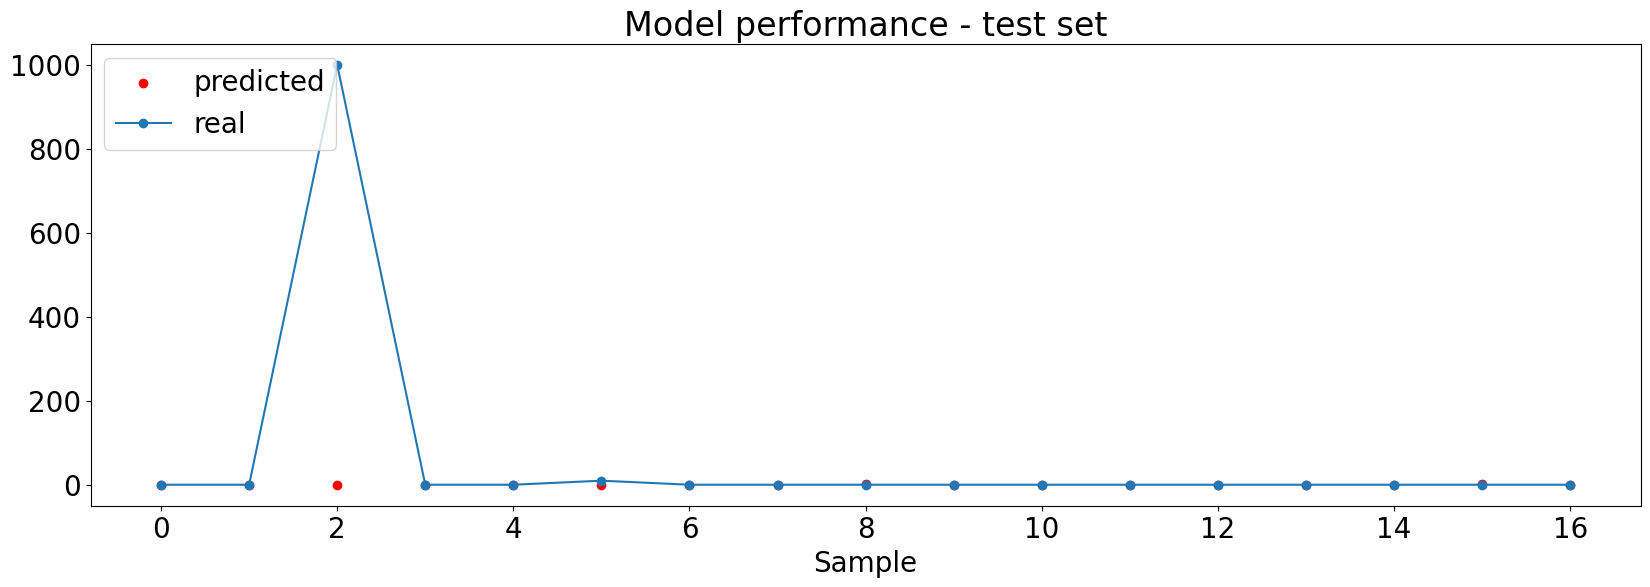

In [ ]:
train_test_model(svm_regressor, xnn_tr, y_tr, xnn_te, y_te, folds=5)

**Teste com 10-Folds**

--------------------Validação Cruazada-----------------------
Média dos valores de MAE: 24.84686596921677
Desvio padrão dos valores de MAE: 26.391506440124452

Média dos valores de MAPE: 345959754543765.4
Desvio padrão dos valores de MAPE: 67108987889236.266

Média dos valores de R2: -0.16062824997887895
Desvio padrão dos valores de R2: 0.0685684596630763

--------------------Teste-----------------------
MAE: 59.603168834310424
MAPE: 1016938002140540.9
R2: -0.06356648125127351


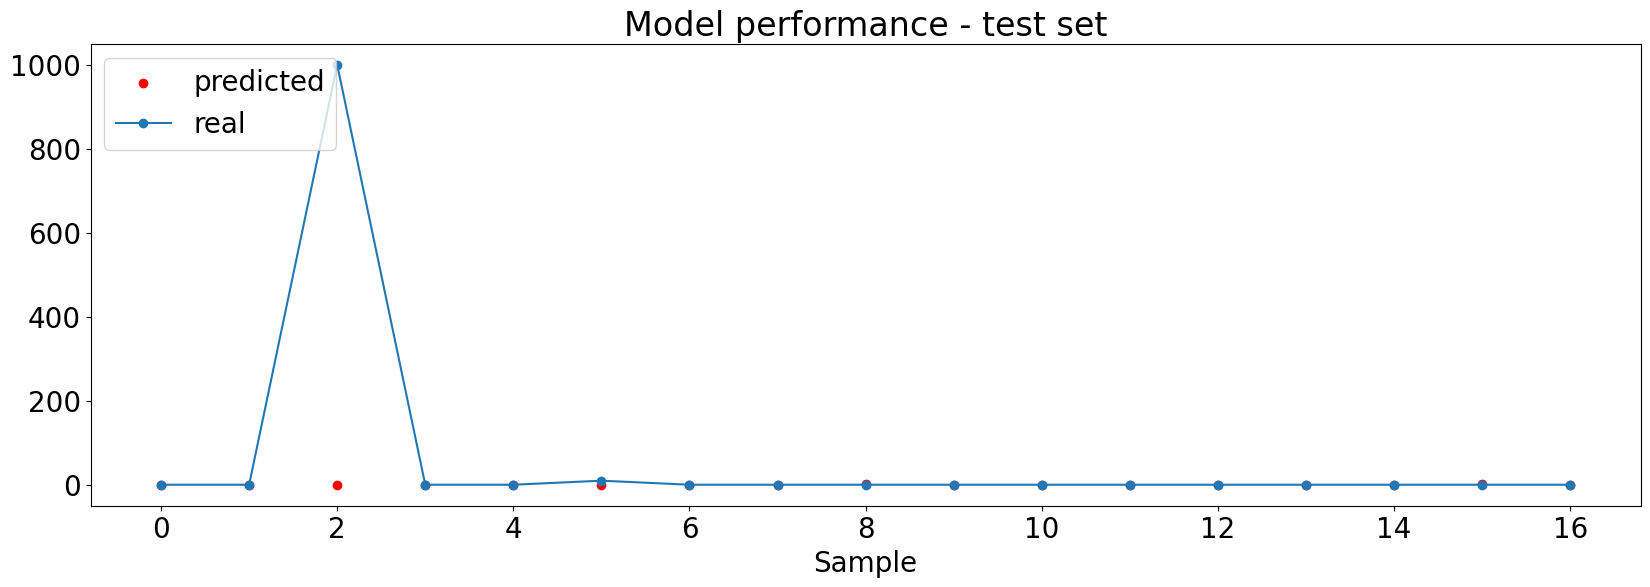

In [ ]:
train_test_model(svm_regressor, xnn_tr, y_tr, xnn_te, y_te, folds=10)